# Flexible Job Shop Scheduling

Operations can be processed on alternative machines with different durations.


## Problem Description

Flexible Job Shop extends the classic job shop by allowing each
operation to run on one of several alternative machines, each with
its own processing time.

Objective: select machines and schedule operations to minimize makespan.


## Mathematical Model

Definitions:
$$
I_{j,o}: \text{main interval}, \quad I_{j,o,m}: \text{optional alternative on machine } m
$$
$$
p_{j,o,m}: \text{duration on machine } m
$$

Constraints:
$$
\text{alternative}(I_{j,o}, \{ I_{j,o,m} \mid m \in M_{j,o} \})
$$
$$
end_{j,o} \le start_{j,o+1} \quad \forall j \in J, \forall o = 0..|O_j|-2
$$
$$
\text{NoOverlap}(\{ I_{j,o,m} \mid m = k \land I_{j,o,m} \text{ present} \}) \quad \forall k \in M
$$

Objective:
$$
\min \max_{j \in J} end_{j,last}
$$


## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
# Flexible operation data
# operation = [(machine_id, duration), ...]
flexible_ops = {
    ('job1', 0): [(0, 5), (1, 4)],
    ('job1', 1): [(1, 3), (2, 2)],
    ('job2', 0): [(0, 3), (2, 4)],
    ('job2', 1): [(0, 2), (1, 3), (2, 2)],
}

job_names = sorted({job for job, _ in flexible_ops})
n_machines = 3


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry

clear_interval_registry()

main_ops = {}
alternatives = {}
machine_intervals = {m: [] for m in range(n_machines)}

for (job, op_idx), choices in flexible_ops.items():
    min_d = min(d for _, d in choices)
    max_d = max(d for _, d in choices)
    main = IntervalVar(size=(min_d, max_d), name=f"{job}_op{op_idx}")
    main_ops[(job, op_idx)] = main
    alternatives[(job, op_idx)] = []

    for machine, duration in choices:
        alt = IntervalVar(size=duration, optional=True, name=f"{job}_op{op_idx}_m{machine}")
        alternatives[(job, op_idx)].append((machine, alt))
        machine_intervals[machine].append(alt)

    satisfy(alternative(main, [alt for _, alt in alternatives[(job, op_idx)]]))

for job in job_names:
    ops_in_job = sorted(op for (j, op) in main_ops if j == job)
    for i in range(len(ops_in_job) - 1):
        before = main_ops[(job, ops_in_job[i])]
        after = main_ops[(job, ops_in_job[i + 1])]
        satisfy(end_before_start(before, after))

sequences = []
for machine, intervals in machine_intervals.items():
    if intervals:
        seq = SequenceVar(intervals=intervals, name=f"machine{machine}")
        sequences.append(seq)
        satisfy(SeqNoOverlap(seq))


In [4]:
last_ops = []
for job in job_names:
    last_op = max(op for (j, op) in main_ops if j == job)
    last_ops.append(main_ops[(job, last_op)])

objective_expr = Maximum(end_time(op) for op in last_ops)
minimize(objective_expr)


## Solve


In [5]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    for job in job_names:
        ops_in_job = sorted(op for (j, op) in main_ops if j == job)
        for op_idx in ops_in_job:
            chosen = None
            for machine, alt in alternatives[(job, op_idx)]:
                val = interval_value(alt)
                if val is not None:
                    chosen = (machine, val)
                    break
            if chosen:
                machine, val = chosen
                print(f"{job} op{op_idx} on M{machine}: [{val.start}, {val.end})")
            else:
                print(f"{job} op{op_idx}: no machine selected")
    makespan = max(interval_value(op).end for op in last_ops)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
job1 op0 on M1: [0, 4)
job1 op1 on M2: [4, 6)
job2 op0 on M0: [0, 3)
job2 op1 on M0: [3, 5)
Makespan: 6


## Stats


In [6]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=13, nb_optional_interval_vars=9, nb_sequences=3, nb_sequences_with_types=0, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=6, solve_time=None, nb_interval_vars=13, nb_intervals_present=8, nb_intervals_absent=5, min_start=0, max_end=6, makespan=6, span=6)


## Visualization


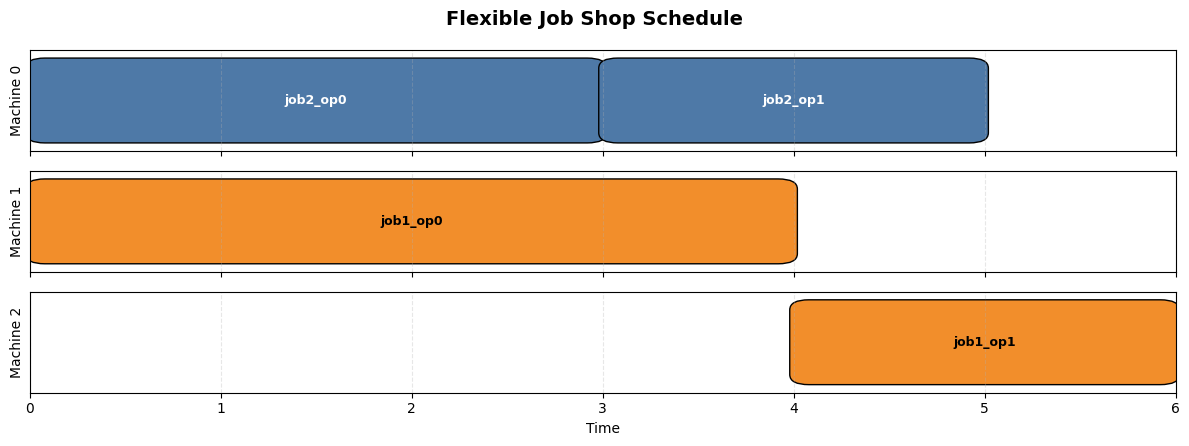

In [7]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(op).end for op in last_ops)
    visu.timeline("Flexible Job Shop Schedule", origin=0, horizon=makespan)

    job_index = {job: idx for idx, job in enumerate(job_names)}
    for m in range(n_machines):
        visu.panel(f"Machine {m}")
        for job in job_names:
            ops_in_job = sorted(op for (j, op) in main_ops if j == job)
            for op_idx in ops_in_job:
                for machine, alt in alternatives[(job, op_idx)]:
                    if machine == m:
                        val = interval_value(alt)
                        if val is not None:
                            visu.interval(val.start, val.end, f"{job}_op{op_idx}", color=job_index[job])

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
